# Spatial domains

**空间组学不能没有空间域，就如同蛋白质不能没有结构域。**

摘要：

- 空间域是反映点或细胞在基因表达方面的相似性以及空间邻近性的簇
- 识别空间域的方法也可以通过空间组学技术纳入可用的组织学信息
- 使用Squidpy和SpaGCN识别空间域

生物信息学就是和数据打交道，我们就是要从数据中挖掘出有用信息，寻找特定的模式。我们有了空间组学数据，就是想着要从中寻找出随空间变化的模式。这个模式，就统称为空间域--Spatial Domain，空间组学不能没有空间域，就如同蛋白质不能没有结构域一般。

空间组学的数据主要包括两大部分：细胞x基因矩阵和空间坐标。此外还有一些附加信息，比如细胞的类型和大小，以及对应的组织学图像等等。

目前有很多识别空间域的算法，基本上可以分为两类：①基于空间远近的基因表达的相似度聚类；②联合组织学图像。

空间远近：
- Spatial domains in Squidpy [Palla et al., 2022]
- Hidden-Markov random field (HMRF) [Dries et al., 2021]
- BayesSpace [Zhao et al., 2021]
联合组织学图像：
- spaGCN [Hu et al., 2021]
- stLearn [Pham et al., 2020]

![Spatial domains overview](https://www.sc-best-practices.org/_images/domains.jpeg)

下面我们来看看到底怎么识别空间域吧！

## 环境配置与数据

安装自不必说，这里我们设置`sc.settings.verbosity = 3，verbosity`是唠叨、冗长的意思，我们设置这个`唠叨级别`为3，这样Scanpy会在运行过程中输出更多的信息和警告，帮助用户更好地了解正在发生的事情。
> Level 0: only show ‘error’ messages. 
> 
> Level 1: also show ‘warning’ messages. 
> 
> Level 2: also show ‘info’ messages. 
> 
> Level 3: also show ‘hint’ messages. 
> 
> Level 4: also show very detailed progress for ‘debug’ging.

In [1]:
# !pip install scanpy
# !pip install squidpy
import scanpy as sc
import squidpy as sq

sc.settings.verbosity = 3
# 设置Scanpy的输出详细程度的命令。详细程度为3时，Scanpy会在运行过程中输出更多的信息和警告，帮助用户更好地了解正在发生的事情。
sc.settings.set_figure_params(dpi=80, facecolor="white")
# 设置图形参数的命令。这里设置了图形的dpi（图像清晰度）为80，以及图形的背景颜色为白色。

我们选择的数据是Squidypy预处理的数据，这是由10x Genomics Space Ranger 1.1.0提供的来自一只小鼠的一个组织切片。

既然是预处理的，我们直接加载即可。

https://squidpy.readthedocs.io/en/stable/api/squidpy.datasets.visium_hne_adata.html

In [2]:
# adata = sq.datasets.visium_hne_adata()
# https://ndownloader.figshare.com/files/26098397
# 报错的话自己下载读取即可
# https://scanpy.readthedocs.io/en/stable/generated/scanpy.read_h5ad.html
adata = sc.read_h5ad("../data/visium_hne.h5ad")
adata

AnnData object with n_obs × n_vars = 2688 × 18078
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

这是预处理的数据，我们看看预处理的cluster的情况。

我们使用`sq.pl.spatial_scatter()`函数，它可以在组织图像的背景上绘制数据的空间分布，也可以只绘制数据的散点图。

/home/zyh/miniconda3/envs/GNN/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)


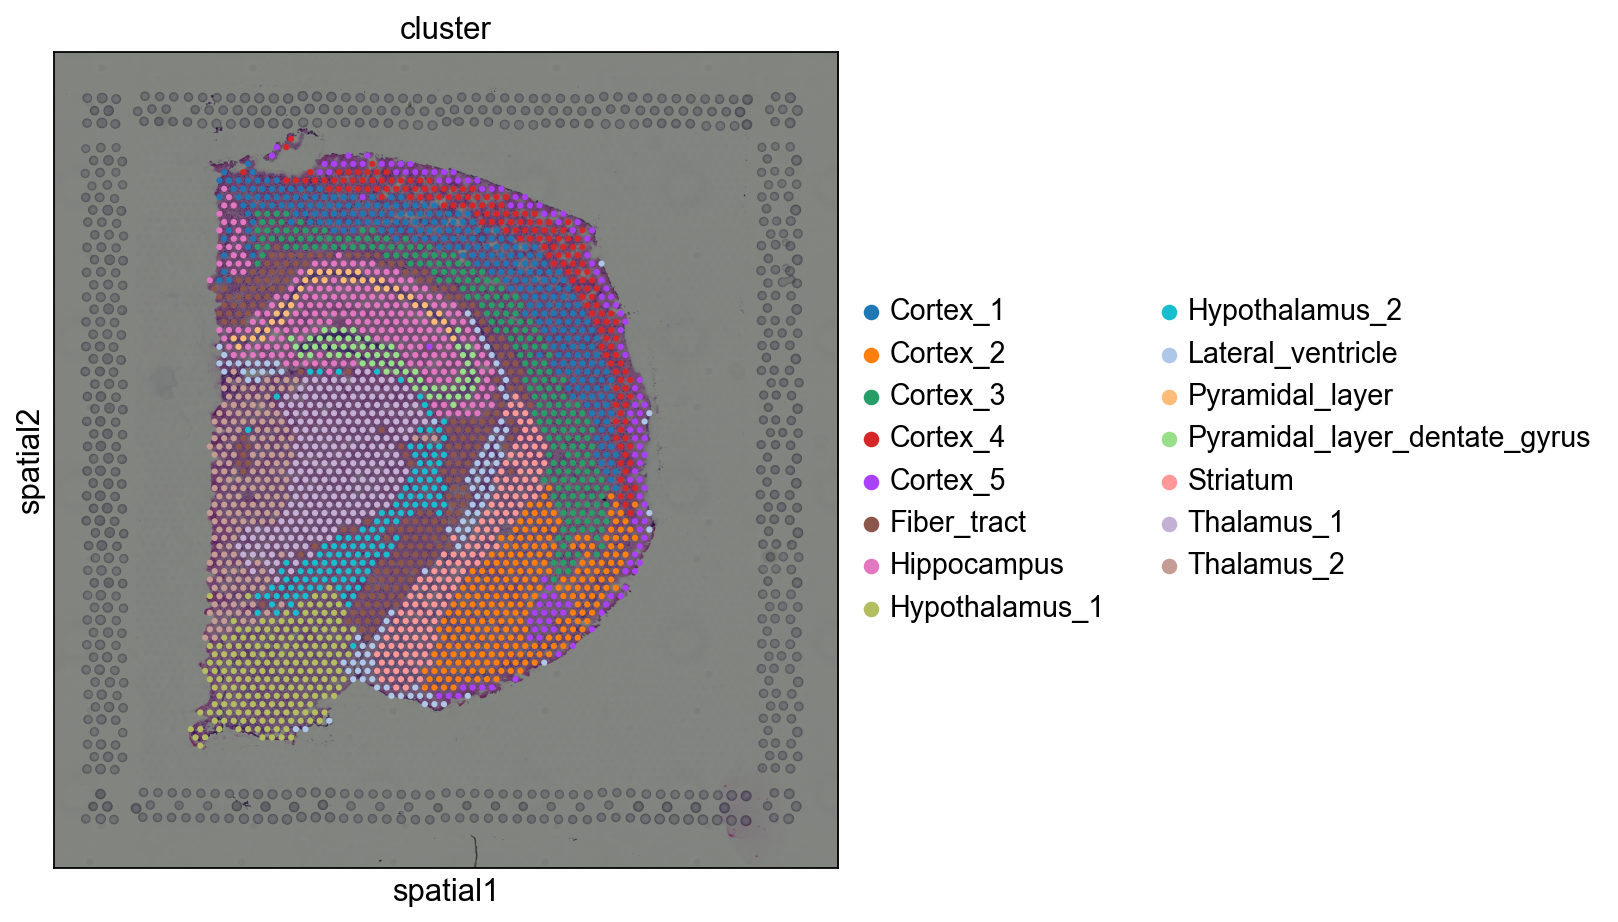

In [3]:
sq.pl.spatial_scatter(adata, color="cluster", figsize=(10, 10))

## Squidpy

首先，我们要在两个不同的空间上计算spot之间的相似性，一个是基因表达空间，一个是空间坐标。为了表示这种相似性，我们可以用最近邻图（也就是空间上的邻居网络）来构建数据点之间的连接关系。

下面的代码用到了`adata.obsm['X_pca']`，这是数据里已经有的，之后我会从原始数据出发的，敬请关注。

In [4]:
# nearest neighbor graph
sc.pp.neighbors(adata)
nn_graph_genes = adata.obsp["connectivities"]
# spatial proximity graph
sq.gr.spatial_neighbors(adata)
nn_graph_space = adata.obsp["spatial_connectivities"]

computing neighbors
    using 'X_pca' with n_pcs = 50


2024-01-29 19:05:12.156250: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-29 19:05:12.156343: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:18)
Creating graph using `grid` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)


第二部，我们要同时考虑两个空间上的相似性，然后来识别数据中的社区（community）或者聚类（cluster）。

一个简单的方法是把两个最近邻图相加，得到一个联合的最近邻图（joint graph），然后在这个图上运行 leiden 算法。leiden 算法是一种基于模块度（modularity）优化的社区检测算法，它可以把数据点划分为不同的社区，使得同一社区内的数据点相似度高，不同社区间的数据点相似度低。

我们还可以用一个超参数 alpha 来调节两个空间上的相似性的重要性。alpha 的值越大，表示空间坐标上的相似性越重要，反之，基因表达上的相似性越重要。这里，我们设置 alpha = 0.2，表示我们更倾向于基于基因表达的相似性。
因此，我们可以用下面的公式来计算联合的最近邻图：

In [5]:
alpha = 0.2
joint_graph = (1 - alpha) * nn_graph_genes + alpha * nn_graph_space

最后，我们用 sc.tl.leiden 函数来在联合的最近邻图上运行 leiden 算法，得到数据点的社区划分，并把结果保存在 adata 对象的 `squidpy_domains` 属性中。

In [6]:
sc.tl.leiden(adata, adjacency=joint_graph, key_added="squidpy_domains")

running Leiden clustering
    finished: found 17 clusters and added
    'squidpy_domains', the cluster labels (adata.obs, categorical) (0:00:00)


让我们来看看识别的空间域和最开始的`cluster`之间的相似程度吧！

由于要画两个图，我们就要设置子图间距，调节`wspace`即可。

- wspace指定了子图之间的水平间距，单位是轴的宽度的百分比1。
- wspace值越大，表示子图之间的水平间距越大，反之，子图之间的水平间距越小。
- 默认值是 0.2，表示子图之间的水平间距是轴的宽度的 20%1。
- 这里，我们设置 wspace = 0.9，表示我们想要增加子图之间的水平间距，使得子图更清晰地分开。

/home/zyh/miniconda3/envs/GNN/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/home/zyh/miniconda3/envs/GNN/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)


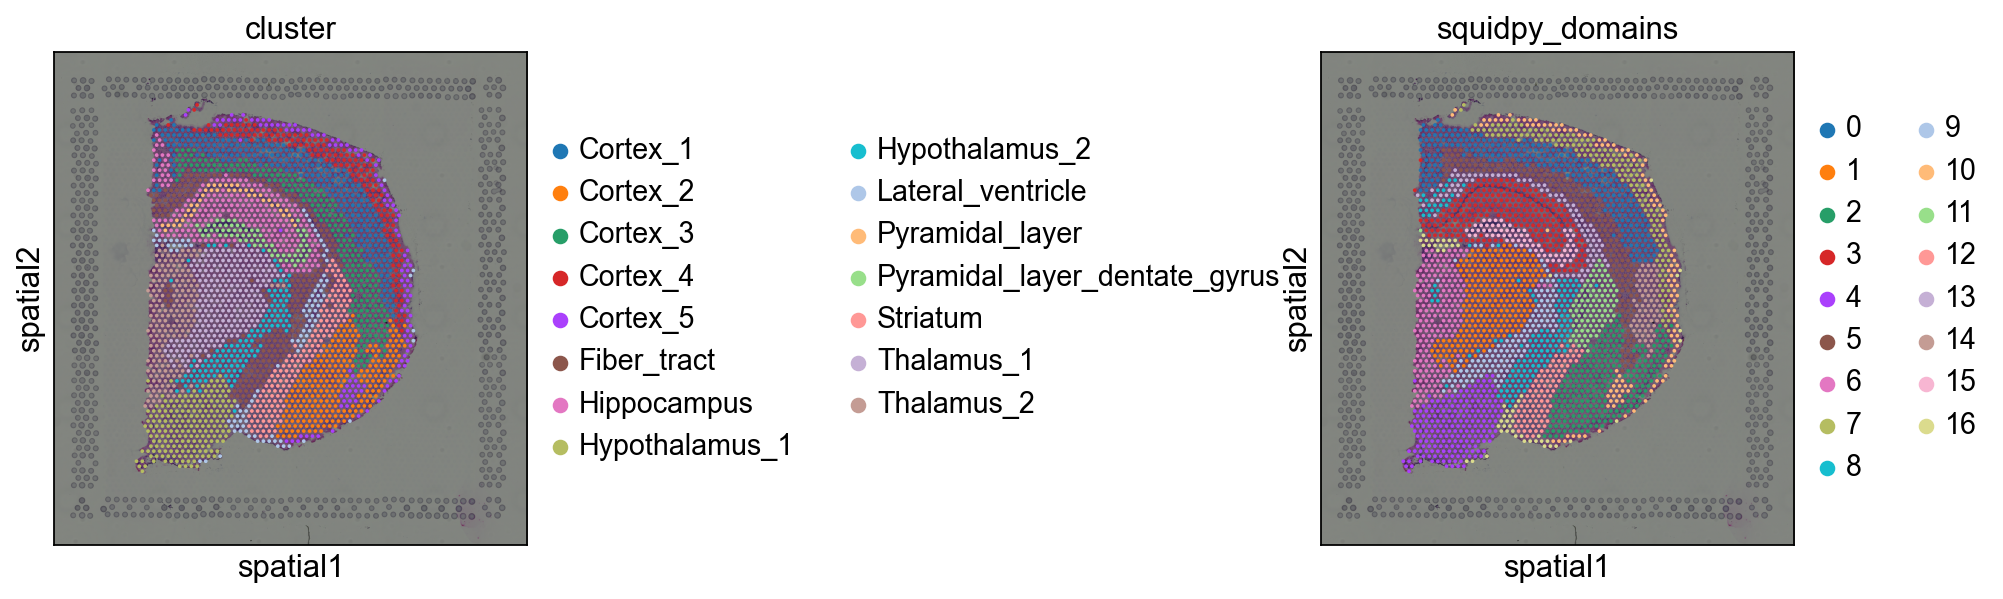

In [7]:
sq.pl.spatial_scatter(adata, color=["cluster", "squidpy_domains"], wspace=0.9)

我们可以看到，这种方法本质上是基于空间距离“平滑”聚类注释。尽管这是一种纯粹的教学方法，但它已在实践中使用[Chen et al.，2022]。

## SpaGCN

SpaGCN是一种利用基因表达、空间位置和组织学进行空间组学数据分析的图卷积神经网络方法。

SpaGCN在无向加权图中结合了基因表达、空间信息和组织学图像。这个图可以表示数据中存在的整体空间依赖关系，然后就可用图卷积来识别空间域。

In [8]:
# !pip install SpaGCN
import SpaGCN as spg

import numpy as np
from PIL import Image
import requests

前面提到了，SpaGCN利用了额外的组织学图像数据。我们就通过request从10x Genomics网站上加载高分辨率的tif文件。

不过SpaGCN也可以不利用组织学信息，我们等会儿再说。

In [9]:
img = np.asarray(
    Image.open(
        requests.get(
            "https://cf.10xgenomics.com/samples/spatial-exp/1.1.0/V1_Adult_Mouse_Brain/V1_Adult_Mouse_Brain_image.tif",
            stream=True,
        ).raw
    )
)

/home/zyh/miniconda3/envs/GNN/lib/python3.10/site-packages/PIL/Image.py:3157: DecompressionBombWarning: Image size (132748287 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


我们的anndata数据是经过预处理的，SpaGCN是需要原始数据的，所以我们就重置`adata.X`。

### 将基因表达和组织学整合到一个图上

SpaGCN需要把spatial array的坐标和pixel的坐标传入模型。前者存放在 `adata.obs["array_row"]` 和 `adata.obs["array_col"]`，后者存放在`adata.obsm["spatial"]`。

In [10]:
# Set coordinates
x_array = adata.obs["array_row"].tolist()
y_array = adata.obs["array_col"].tolist()
x_pixel = (adata.obsm["spatial"][:, 0]).tolist()
y_pixel = adata.obsm["spatial"][:, 1].tolist()

SpaGCN首先把基因表达和组织学信息以邻接矩阵的形式整合到一张图上。两个点相连的条件是物理上里的很近并且又相似的组织学特征。下面就是对应的函数了，除了需要输入坐标，还有两个参数：
- `beta`决定了在提取color intensity是每个spot的面积。这个值通常来说存储在`adata.uns['spatial]`。Visium spot一般是55~100$\mu m$。
- `alpha`决定了在计算点之间的欧式距离时给组织学图像的权重。alpha=1表示组织学像素强度值与(x,y)坐标具有相同的scale cariance。

In [11]:
# Calculate adjacent matrix
adj = spg.calculate_adj_matrix(
    x=x_pixel,
    y=y_pixel,
    x_pixel=x_pixel,
    y_pixel=y_pixel,
    image=img,
    beta=55,
    alpha=1,
    histology=True,
)

Calculateing adj matrix using histology image...
Var of c0,c1,c2 =  96.93674686223055 519.0133178897761 37.20274924909862
Var of x,y,z =  2928460.011122931 4665090.578837907 4665090.578837907


### 基因表达数据质控与预处理

接下来就是基因表达数据的常规操作了，过滤掉只在不足3个spot中表达的基因。然后把counts进行标准化和对数转换。

In [12]:
adata.var_names_make_unique()

sc.pp.filter_genes(adata, min_cells=3)

# find mitochondrial (MT) genes
adata.var["MT_gene"] = [gene.startswith("MT-") for gene in adata.var_names]
# remove MT genes (keeping their counts in the object)
adata.obsm["MT"] = adata[:, adata.var["MT_gene"].values].X.toarray()
adata = adata[:, ~adata.var["MT_gene"].values].copy()

# Normalize and take log for UMI
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


### SpaGCN的超参

第一步，SpaGCN找到characteristiv length scale $l$。这个参数决定了权重作为距离函数衰减的速度。要找到$l$，首先必须指定参数$p$，$p$描述由邻域贡献占总表达量的百分比。对于Visium数据，SpaGCN建议使用“p=0.5”。对于Slide-seq V2或MERFISH等捕获区域较小的数据，建议选择较高的贡献值。

In [13]:
p = 0.5
# Find the l value given p
l = spg.search_l(p, adj)

Run 1: l [0.01, 1000], p [0.0, 176.04695830342547]
Run 2: l [0.01, 500.005], p [0.0, 38.50406265258789]
Run 3: l [0.01, 250.0075], p [0.0, 7.22906494140625]
Run 4: l [0.01, 125.00874999999999], p [0.0, 1.119886875152588]
Run 5: l [62.509375, 125.00874999999999], p [0.07394278049468994, 1.119886875152588]
Run 6: l [93.7590625, 125.00874999999999], p [0.4443991184234619, 1.119886875152588]
Run 7: l [93.7590625, 109.38390625], p [0.4443991184234619, 0.7433689832687378]
Run 8: l [93.7590625, 101.571484375], p [0.4443991184234619, 0.5843360424041748]
Run 9: l [93.7590625, 97.66527343749999], p [0.4443991184234619, 0.5119975805282593]
Run 10: l [95.71216796875, 97.66527343749999], p [0.47760796546936035, 0.5119975805282593]
recommended l =  96.688720703125


如果组织中的spatial domain数量是已知的，SpaGCN就可以计算出一个合适的分辨率去生成对应的个数的空间域。一般来说，在大脑样本会这样，比如我们像在切片中找到一定数目的皮层（cortex），如果不给定空间域的个数，那么SpaGCN的分辨率参数就会在0.2到0.1选择具有最高的轮廓系数的值。

在我们的数据中就定为15。

In [15]:
# Search for suitable resolution
res = spg.search_res(adata, adj, l, target_num=15)

Start at res =  0.4 step =  0.1
Initializing cluster centers with louvain, resolution =  0.4
computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
Epoch  0
Res =  0.4 Num of clusters =  9


Initializing cluster centers with louvain, resolution =  0.5
computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
Epoch  0
Res =  0.5 Num of clusters =  10
Res changed to 0.5
Initializing cluster centers with louvain, resolution =  0.6
computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:

我们现在已经计算了初始化SpaGCN的所有参数，首先来设置$l$。

In [16]:
model = spg.SpaGCN()
model.set_l(l)

然后我们开始训练模型，使用我们刚刚找到的分辨率和规定的15个空间域。

In [17]:
model.train(adata, adj, res=res)

Initializing cluster centers with louvain, resolution =  0.7999999999999999
computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
Epoch  0
Epoch  10
Epoch  20
Epoch  30
Epoch  40
Epoch  50
Epoch  60
Epoch  70
delta_label  0.0003720238095238095 < tol  0.001
Reach tolerance threshold. Stopping training.
Total epoch: 73


我们现在就开始预测数据集中每个细胞的空间域。另外模型还会返回细胞属于哪个空间域的概率，不过我们这次暂时用不到。

In [19]:
y_pred, prob = model.predict()

我们把识别的空间域保存到`adata.obs`并且转换为分类变量，这样方便可视化。

In [20]:
adata.obs["spaGCN_domains"] = y_pred
adata.obs["spaGCN_domains"] = adata.obs["spaGCN_domains"].astype("category")

让我们来和原始的cluster对比一下吧。

/home/zyh/miniconda3/envs/GNN/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/home/zyh/miniconda3/envs/GNN/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)


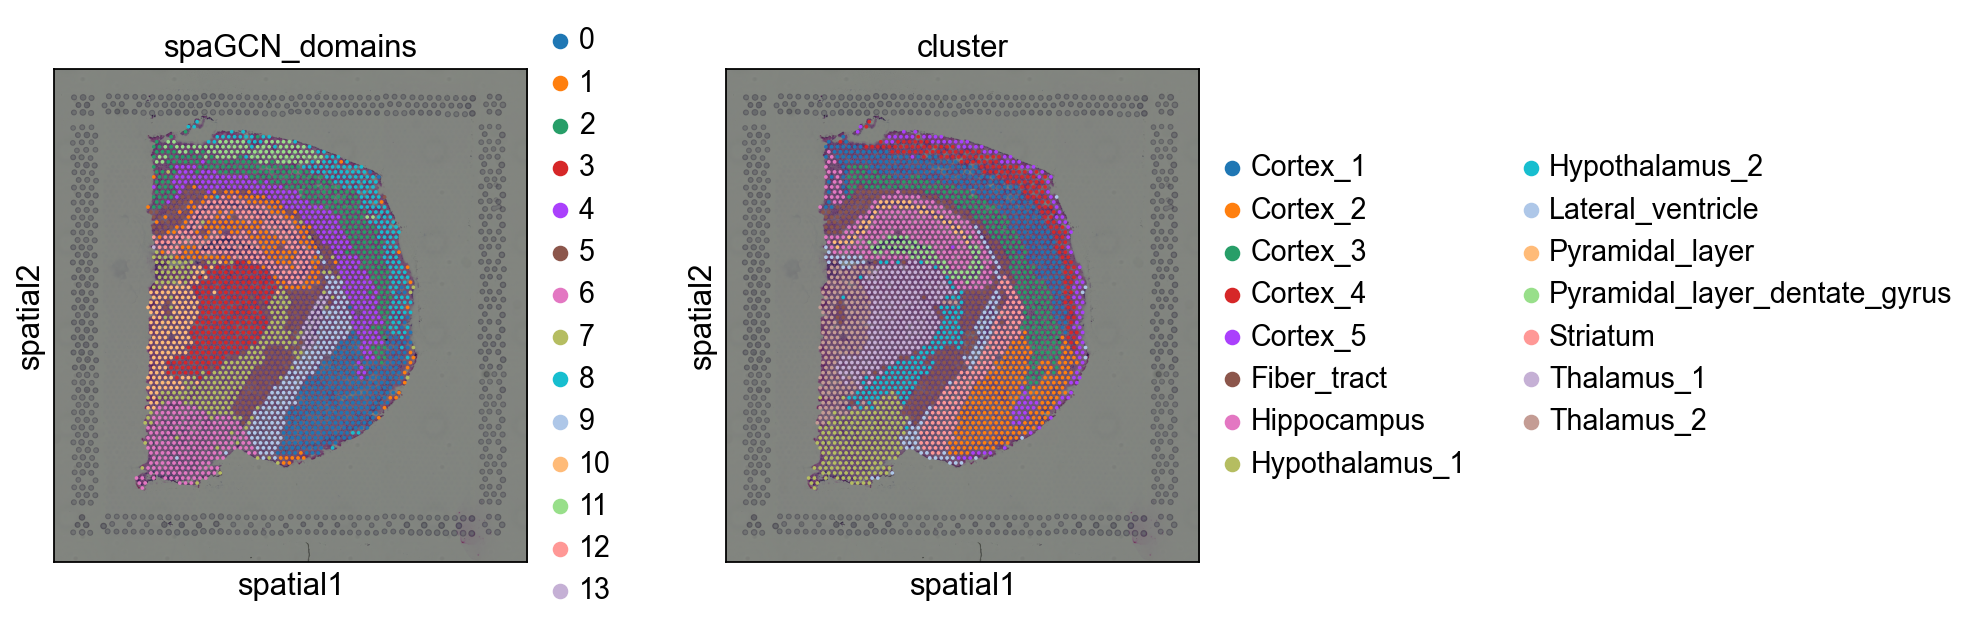

In [21]:
sq.pl.spatial_scatter(adata, color=["spaGCN_domains", "cluster"])

我们可以看到，SpaGCN非常准确地识别了空间域。不过我们可以观察到一些不完美的异常值。SpaGCN提供了一个函数来细化空间域，我们现在来看看这个函数吧。

### 优化空间域

SpaGCN包括一个可选的改进步骤，以增强聚类结果，这个步骤检查每个点及其相邻点的域分配。如果超过一半的相邻spot被分配到不同的域，则该spot将被重新标记为其相邻spot的主域。细化步骤将只影响几个spot。通常，SpaGCN只建议在数据集期望具有明确的域边界时进行细化。

简单来说就是看看spot的邻居，如果邻居都是A，而它是B，就把B变成A。

这个步骤SpaGCN首先计算邻接矩阵，而不考虑组织学图像。

In [22]:
adj_2d = spg.calculate_adj_matrix(x=x_array, y=y_array, histology=False)

Calculateing adj matrix using xy only...


用邻接矩阵和刚刚识别的空间域来优化。

In [23]:
refined_pred = spg.refine(
    sample_id=adata.obs.index.tolist(),
    pred=adata.obs["spaGCN_domains"].tolist(),
    dis=adj_2d,
)

依然保存，并转换为分类变量。

In [24]:
adata.obs["refined_spaGCN_domains"] = refined_pred
adata.obs["refined_spaGCN_domains"] = adata.obs["refined_spaGCN_domains"].astype(
    "category"
)

我们来看看这三次的识别空间域的结果吧。

/home/zyh/miniconda3/envs/GNN/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/home/zyh/miniconda3/envs/GNN/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/home/zyh/miniconda3/envs/GNN/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None

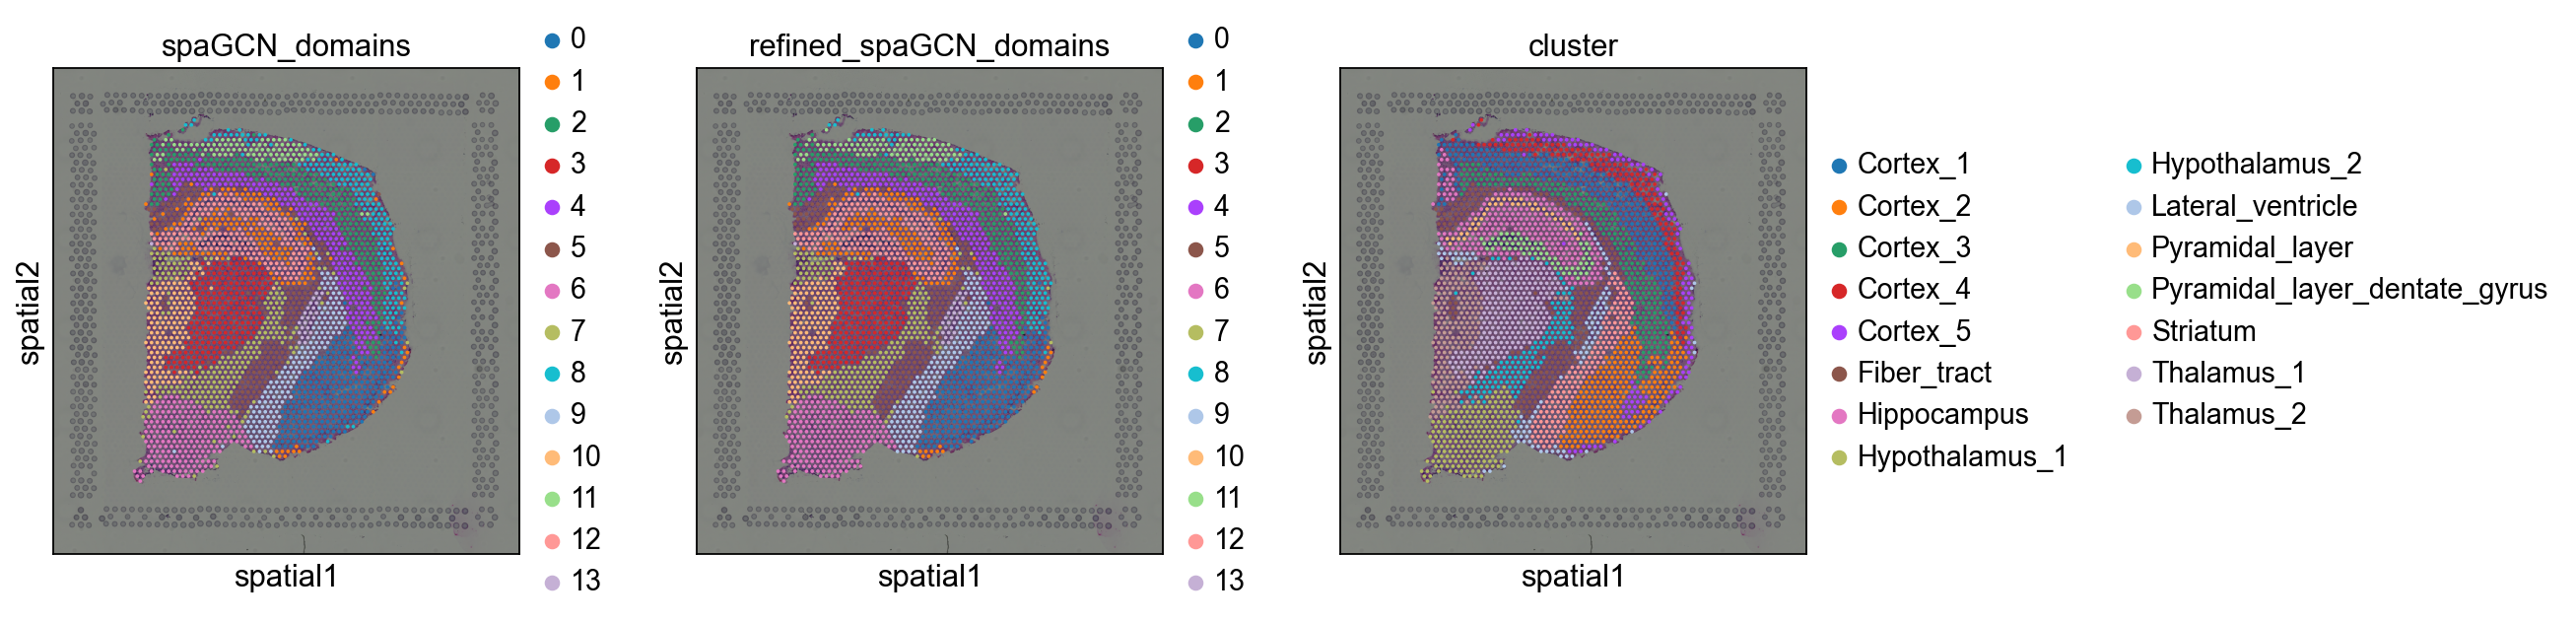

In [29]:
sq.pl.spatial_scatter(adata, color=["spaGCN_domains", "refined_spaGCN_domains", "cluster"])

可以看到第一张图的橙色区域的一些异常值就被优化了。

## 参考文献
> https://www.sc-best-practices.org/spatial/domains.html